In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, Printf, IndexedGraphs, Statistics, Random
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2;

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [2]:
include("../../telegram/notifications.jl");

In [74]:
T = 50
N = 100
c = 3
gg = erdos_renyi(N, c/N)
# k = 4
# gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 16 /3 / 50
ρ = 1 / 30
σ = 1 / 30
γ = 0.02;

In [132]:
rng = MersenneTwister(111)
sis = SIRS(g, λ, ρ, σ, T; γ)
# sis = SIS(g, λ, ρ, T; γ)
bp = mpbp(sis)
cb = CB_BP(bp);

In [133]:
obs_times = [30]
nobs = N * length(obs_times)
obs_fraction = N / nobs
X, observed = draw_node_observations!(bp, nobs, times = obs_times .+ 1, softinf=Inf; rng);
# X, observed = draw_node_observations!(bp, nobs, softinf=Inf; rng);

In [134]:
reset!(bp);

In [ ]:
svd_trunc = TruncBond(8)
@telegram "sis inference single instance" begin
    iters, cb = iterate!(bp, maxiter=50; svd_trunc, cb, tol=1e-3, damp=0.5);
end;

Running MPBP: iter 10 	 Time: 0:20:59
  Δ:                0.0017188917712942023
  SVD Matrix size:  8

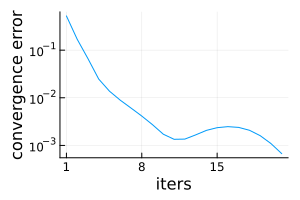

In [145]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [146]:
b_bp = beliefs(bp)
p_bp = [[bᵗ[INFECTED] for bᵗ in bb] for bb in b_bp];

In [147]:
true_infections = [UnitRange{Int64}[] for _ in 1:N]
for i in 1:N
    start = -1
    for t in 1:T+1
        if X[i,t] == INFECTED
            start == -1 && (start = t)
        else
            start != -1 && ( push!(true_infections[i], start-1:t-2); start = -1 )
        end
    end
    start != -1 && push!(true_infections[i], start-1:T)
end

In [148]:
using ColorSchemes
cg = cgrad(:deep)[1:150]
cg = cgrad(:GnBu_3, rev=true)
cg = cgrad(:haline)[150:end]
cg = cgrad(:tokyo, rev=false)[50:end]
cg = cgrad(:viridis, alpha=1.0)[80:end]
cg = cgrad([theme_palette(:auto)[1], :yellow], 0.6)

In [149]:
X_bp = reduce(hcat, p_bp)

perm = sortperm(true_infections)
# perm = collect(eachindex(true_infections))
true_infections_sorted = true_infections[perm]
X_bp_sorted = X_bp[:,perm]

pl = heatmap(1:N, 0:T, X_bp_sorted, c=cg, xlabel="i", ylabel="t", colorbar_title="\$P(x_i^t=I)\$")

pl2 = deepcopy(pl)
pl3 = plot(xlabel="i", ylabel="t", xlims=(1,N));

In [150]:
for (i,t) in observed
    scatter!(pl, invperm(perm)[i:i], [t-1], m=:o, ms=3, msc=:auto, c=:red, label="")
end

In [151]:
label = "true infections"
for i in 1:N
    for a in true_infections_sorted[i]
        plot!(pl, [i,i], [a.start-0.1,a.stop+0.1], c=:black, label=label, lw=1)
        label = ""
        plot!(pl3, [i,i], [a.start-0.1,a.stop+0.1], c=:black, label=label, lw=1)
    end
end

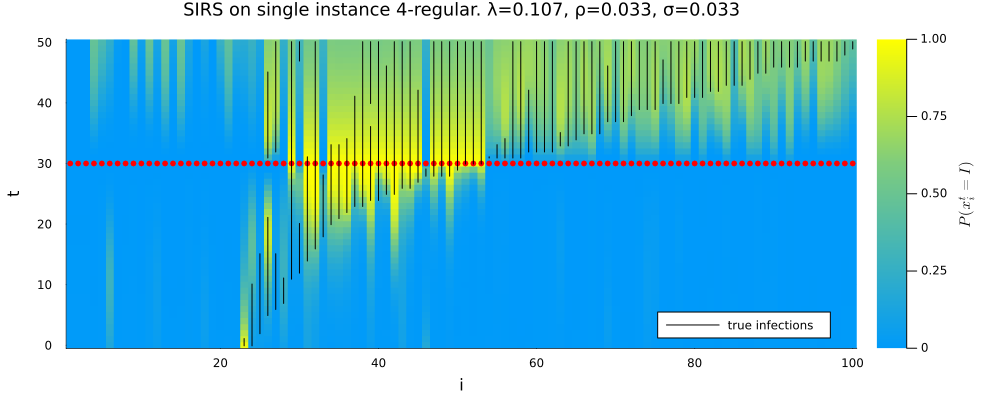

In [152]:
# hline!(pl, obs_times, c=:orange, ls=:dash, label="observations", legend=:outertopright,
#     size=(1000,400))
# println("Observations at times: ", obs_times)
plot(pl, margin=5Plots.mm, 
    title="SIRS on single instance $k-regular. λ=$(round(λ, digits=3)), ρ=$(round(ρ, digits=3)), σ=$(round(σ, digits=3))",
    #Fraction of observed nodes: $(round(obs_fraction, digits=3))", 
    titlefontsize=12, size=(1000,400), legend=:bottomright, yticks=0:(T÷5):T, widen=false)

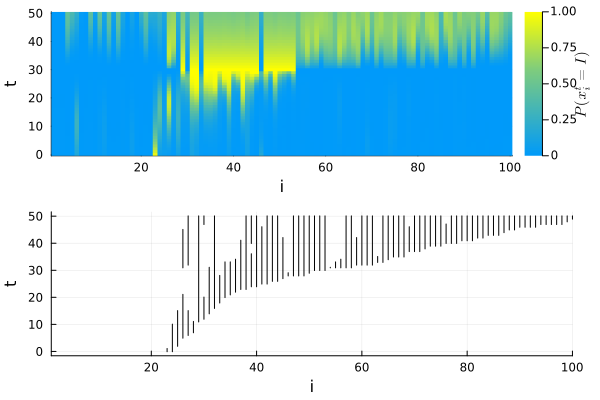

In [153]:
plot(pl2, pl3, layout=(2,1))

In [ ]:
# jldsave("plot_data/sis_inference_single_instance.jld2"; 
#     N, T, X_bp, true_infections, obs_times, k, λ, ρ, obs_fraction);